# Predictive Weather Analysis using an ARIMA-based Machine Learning Model

### Check for successful imports

In [645]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from itertools import product
from tqdm import tqdm_notebook
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error 
print("Imported Successfully")

Imported Successfully


### Read in the csv file

In [646]:
data = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')
print("Imported Successfully")

Imported Successfully


### Drop any duplicate values

In [647]:
city_data = data.drop_duplicates(['City'])
city_data.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1977,1850-01-01,15.986,1.537,Addis Abeba,Ethiopia,8.84N,38.11E
3942,1796-01-01,19.649,2.286,Ahmadabad,India,23.31N,72.52E
6555,1791-05-01,20.836,1.993,Aleppo,Syria,36.17N,37.79E
9224,1791-05-01,20.772,1.848,Alexandria,Egypt,31.35N,30.16E


### Create a list of the data and drop any NaN using backfill

In [648]:
la_data = data[data['City']=='Los Angeles']
la_data['AverageTemperature']=la_data.AverageTemperature.fillna(method='bfill')

/tmp/ipykernel_142008/2531490639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  la_data['AverageTemperature']=la_data.AverageTemperature.fillna(method='bfill')


### Reset the index of the data, drop the index column, and assemble a date time list
### Create a dataframe using only data from Los Angeles. 

In [649]:
la_data = la_data.reset_index()
la_data = la_data.drop(columns=['index'])
la_data.dt = pd.to_datetime(la_data.dt)

### append necessary values

In [650]:
year = []
month = []
day = []
for i in range(len(la_data)):
    day.append(la_data.dt[i].day)
    month.append(la_data.dt[i].month)
    year.append(la_data.dt[i].year)

### Add a title 

In [651]:
la_data['Year'] = year
la_data['Month'] = month
la_data['Day'] = day 

### Append Years to frame

In [652]:
year_index = []
change_year = []
year_list = la_data['Year'].tolist()
for y in range(0,len(year_list)-1):
    if year_list[y]!=year_list[y+1]:
        change_year.append(year_list[y+1])
        year_index.append(y+1)

In [653]:
la_data.loc[year_index].head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,Year,Month,Day
12,1850-01-01,7.087,2.513,Los Angeles,United States,34.56N,118.70W,1850,1,1
24,1851-01-01,7.549,3.123,Los Angeles,United States,34.56N,118.70W,1851,1,1
36,1852-01-01,8.236,2.536,Los Angeles,United States,34.56N,118.70W,1852,1,1
48,1853-01-01,8.159,2.156,Los Angeles,United States,34.56N,118.70W,1853,1,1
60,1854-01-01,7.849,2.058,Los Angeles,United States,34.56N,118.70W,1854,1,1


### Method to grab a data between a specified range

In [654]:
def get_time(start_year,end_year):
    year_data = la_data[(la_data.Year>=start_year) & (la_data.Year<=end_year)].reset_index().drop(columns=['index'])
    return year_data

### Perform AD Fuller test to determine if data is stationary 

In [655]:
result = adfuller(la_data.AverageTemperature)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -5.491785895067192
p-value: 2.1670713831505364e-06
Critical Values:
	1%: -3.4337079123563106
	5%: -2.8630233240061367
	10%: -2.5675596618014462


### Get the data between 1962 and 2013
### Split the data into a test and training set

In [656]:
temp = get_time(1962,2013)

N = len(temp.AverageTemperature)

split = 0.9

training_size = round(split*N)
test_size = round((1-split)*N)

series = temp.AverageTemperature[:training_size]
date = temp.dt[:training_size]

test_series = temp.AverageTemperature[len(date)-1:len(temp)]
test_date = temp.dt[len(date)-1:len(temp)]

### This is the main conversation that will be had in the paper

In [657]:
def optimize_ARIMA(order_list, exog):
    results = []
    
    for order in tqdm_notebook(order_list):
        model = SARIMAX(exog, order=order).fit(disp=-1)
        aic = model.aic
        results.append([order, model.aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

### The model will be decided by the Akaike information criterion which checks for prediction error


In [658]:
ps = range(0, 10, 1)
d = 1
qs = range(0, 10, 1)

parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)
    
result = optimize_ARIMA(order_list, exog = series)

result

/tmp/ipykernel_142008/2383019444.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/100 [00:00<?, ?it/s]

/home/bryce/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/bryce/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/bryce/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/bryce/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/bryce/anaconda3/lib/python3.9/s

/home/bryce/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/bryce/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/bryce/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/bryce/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/bryce/anaconda3/lib/python3.9/site-packages/statsmodels/base/model

,"(p, d, q)",AIC
0,"(6, 1, 6)",1977.551319
1,"(5, 1, 6)",1984.872786
2,"(7, 1, 7)",1988.080819
3,"(5, 1, 8)",1994.248198
4,"(6, 1, 7)",1996.236774
...,...,...
95,"(2, 1, 0)",2801.677576
96,"(1, 1, 0)",2803.606348
97,"(1, 1, 1)",2804.046494
98,"(0, 1, 1)",2850.813909


### Print results of predictions

In [659]:
result.head()

,"(p, d, q)",AIC
0,"(6, 1, 6)",1977.551319
1,"(5, 1, 6)",1984.872786
2,"(7, 1, 7)",1988.080819
3,"(5, 1, 8)",1994.248198
4,"(6, 1, 7)",1996.236774


In [660]:
result_0 = result[result.columns[0]][0]
# print(best_model_params_0)

### Fit the model and display a summary of the results

In [661]:
result_00 = SARIMAX(series, order=result_0).fit()
print(result_00.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08633D+00    |proj g|=  2.04283D+00

At iterate    5    f=  1.91995D+00    |proj g|=  1.63592D-01

At iterate   10    f=  1.87128D+00    |proj g|=  2.57165D-01

At iterate   15    f=  1.84042D+00    |proj g|=  1.22686D+00

At iterate   20    f=  1.81362D+00    |proj g|=  2.54206D+00

At iterate   25    f=  1.77855D+00    |proj g|=  1.32730D+00

At iterate   30    f=  1.75353D+00    |proj g|=  7.68114D-01

At iterate   35    f=  1.74796D+00    |proj g|=  7.17968D-02

At iterate   40    f=  1.74696D+00    |proj g|=  1.81143D-01

At iterate   45    f=  1.74588D+00    |proj g|=  2.50796D-02

At iterate   50    f=  1.74557D+00    |proj g|=  1.18576D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/bryce/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/home/bryce/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


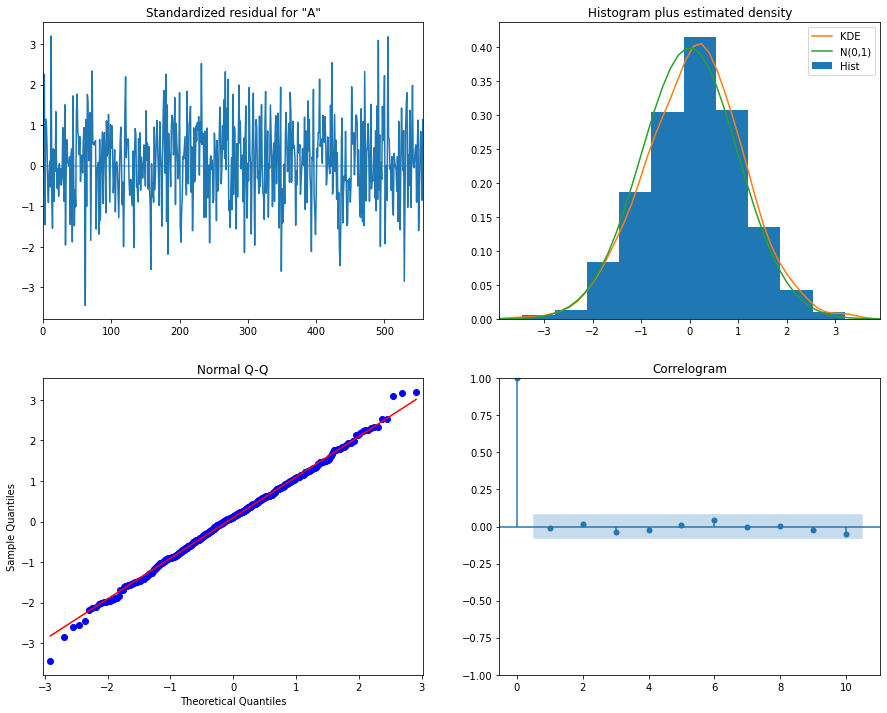

In [662]:
result_00.plot_diagnostics(figsize=(15,12))
plt.show()

### Create predictions of simulated forecast

In [663]:
forecast = result_00.get_prediction(start=training_size, end=training_size+test_size-1)
forecast_average = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.05)


forecast_average

559    24.791612
560    21.976972
561    17.050289
562    12.673943
563     9.898744
         ...    
616    18.355456
617    22.060638
618    24.706764
619    24.672483
620    21.738371
Name: predicted_mean, Length: 62, dtype: float64

### Set bounds for graphs

In [664]:
error_test=la_data.loc[test_date[1:].index.tolist()].AverageTemperatureUncertainty
test_set = test_series[1:]

In [665]:
lower_test = test_set-error_test
upper_test = test_set+error_test

### Plot error range and confidence interval

Text(0.5, 0, 'Simulated Months')

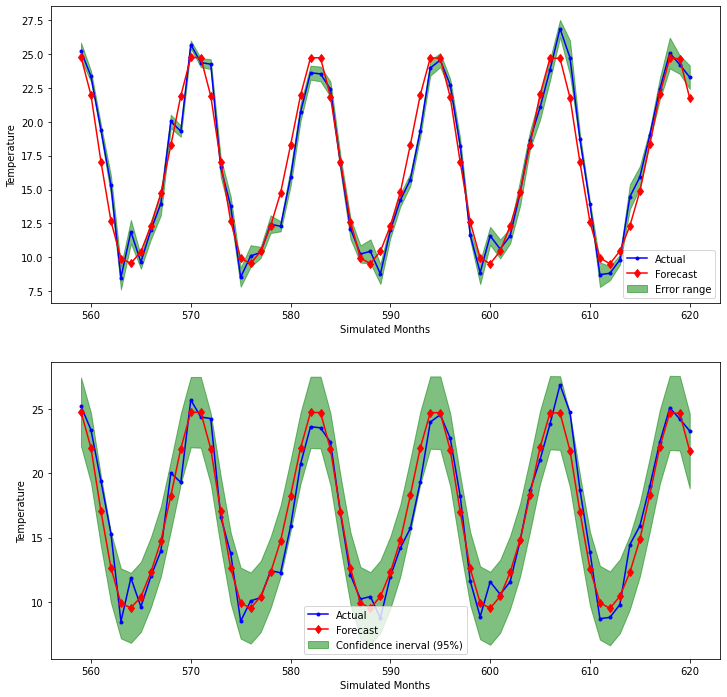

In [666]:
plt.figure(figsize=(12,12))
x1=la_data.AverageTemperature.index[training_size:training_size+test_size]

plt.subplot(2,1,1)
plt.fill_between(x1, lower_test, upper_test,alpha=0.5, label = 'Error range',color='g')
plt.plot(test_set,marker='.',label="Actual",color='b')
plt.plot(forecast_average,marker='d',label="Forecast",color='r')
plt.xlabel('Simulated Months')
plt.ylabel('Temperature')
plt.legend()


plt.subplot(2,1,2)
plt.plot(test_set,marker='.',label="Actual",color='b')
plt.plot(forecast_average,marker='d',label="Forecast",color='r')
plt.fill_between(x1, ci['lower AverageTemperature'], ci['upper AverageTemperature'],alpha=0.5, label = 'Confidence inerval (95%)',color='g')
plt.legend()
plt.ylabel('Temperature')
plt.xlabel('Simulated Months')

Text(0.5, 0, 'Simulated Months')

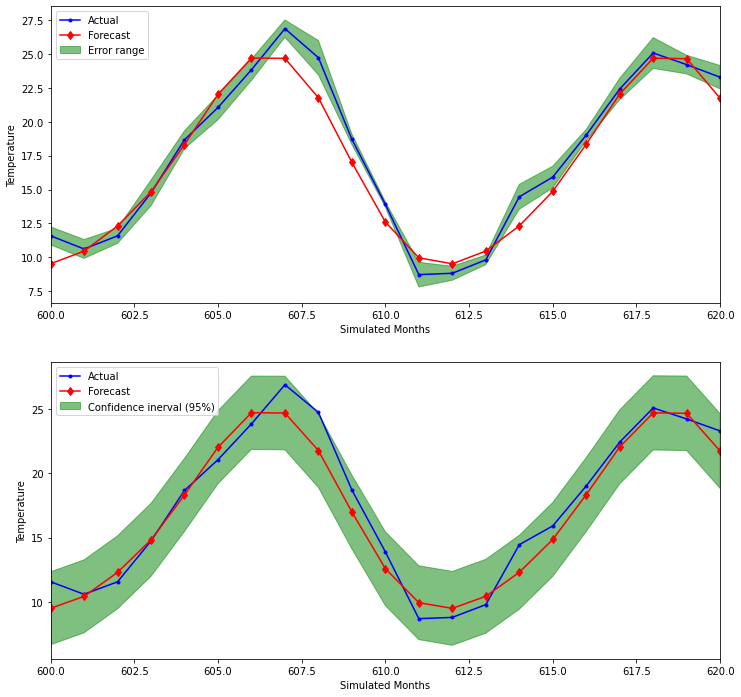

In [667]:
plt.figure(figsize=(12,12))
x1=la_data.AverageTemperature.index[training_size:training_size+test_size]

plt.subplot(2,1,1)
plt.fill_between(x1, lower_test, upper_test,alpha=0.5, label = 'Error range',color='g')
plt.plot(test_set,marker='.',label="Actual",color='b')
plt.plot(forecast_average,marker='d',label="Forecast",color='r')
plt.xlabel('Simulated Months')
plt.ylabel('Temperature')
plt.xlim(600, 620)
plt.legend()


plt.subplot(2,1,2)
plt.plot(test_set,marker='.',label="Actual",color='b')
plt.plot(forecast_average,marker='d',label="Forecast",color='r')
plt.fill_between(x1, ci['lower AverageTemperature'], ci['upper AverageTemperature'],alpha=0.5, label = 'Confidence inerval (95%)',color='g')
plt.xlim(600, 620)
plt.legend()
plt.ylabel('Temperature')
plt.xlabel('Simulated Months')

In [668]:
mse = mean_squared_error(test_set, forec)
mse

1.9280713556767897